# 데이터 수집

In [1]:
import scanpy as sc
import pandas as pd
import os

# 데이터가 있는 폴더 경로
data_path = '/Users/jeongminpark/Documents/Bioinformatics/scRNA' 

# 1. 발현량 행렬(Matrix) 읽기 (.T는 행렬 전치: 유전자를 컬럼으로, 세포를 행으로) ; 생물학과 데이터 과학의 방식이 다름.
adata = sc.read_mtx(os.path.join(data_path, 'GSE140228_UMI_counts_Droplet.mtx.gz')).T

# 2. 유전자 이름(Features) 및 세포 바코드(Barcodes) 읽기
genes = pd.read_csv(os.path.join(data_path, 'GSE140228_UMI_counts_Droplet_genes.tsv.gz'), sep='\t', header=None)
barcodes = pd.read_csv(os.path.join(data_path, 'GSE140228_UMI_counts_Droplet_barcodes.tsv.gz'), sep='\t', header=None)

# 유전자 중복으로 인한 문제 해결
n_genes_matrix = adata.shape[1]
n_genes_list = len(genes)

print(f"매트릭스 유전자 수: {n_genes_matrix}")
print(f"유전자 목록 파일 행 수: {n_genes_list}")

#해결책: 목록이 1개 더 많으면 맨 윗줄(Header)을 제거
if n_genes_list == n_genes_matrix + 1:
    genes = genes.iloc[1:].reset_index(drop=True)

    
# AnnData 객체에 이름 부여
adata.var_names = genes[1].values  # 유전자 심볼 (Symbol)
adata.obs_names = barcodes[0].values  # 세포 바코드

# 3. 메타데이터(세포 정보: 암/정상 여부, 환자 정보 등) 합치기
cell_info = pd.read_csv(os.path.join(data_path, 'GSE140228_UMI_counts_Droplet_cellinfo.tsv.gz'), sep='\t', index_col=0)
adata.obs = adata.obs.join(cell_info)

# 4. 결과 확인
print(adata)

매트릭스 유전자 수: 54574
유전자 목록 파일 행 수: 54575
AnnData object with n_obs × n_vars = 66187 × 54574
    obs: 'Donor', 'Tissue', 'celltype_sub', 'Platform', 'celltype_global', 'Sample', 'Histology', 'Tissue_sub'


# 데이터 전처리

In [2]:
# 1. 세포 정보에 들어있는 컬럼 이름들을 모두 출력
print(adata.obs.columns)

# 2. 데이터 앞부분을 조금만 눈으로 확인
print(adata.obs.head())

Index(['Donor', 'Tissue', 'celltype_sub', 'Platform', 'celltype_global',
       'Sample', 'Histology', 'Tissue_sub'],
      dtype='object')
                                    Donor   Tissue     celltype_sub Platform  \
AAACCTGAGAGCCCAA-1-D20171109_A  D20171109  Ascites       Mφ-C5-VCAN  Droplet   
AAACCTGGTGCTAGCC-1-D20171109_A  D20171109  Ascites      CD8-C6-GZMK  Droplet   
AAACGGGAGAGACTAT-1-D20171109_A  D20171109  Ascites  CD4/CD8-C1-CCR7  Droplet   
AAACGGGAGCGTAATA-1-D20171109_A  D20171109  Ascites      Mφ-C6-MARCO  Droplet   
AAACGGGAGCTGAAAT-1-D20171109_A  D20171109  Ascites     DC-C2-FCER1A  Droplet   

                               celltype_global       Sample Histology  \
AAACCTGAGAGCCCAA-1-D20171109_A         Myeloid  D20171109_A       HCC   
AAACCTGGTGCTAGCC-1-D20171109_A      Lymphoid-T  D20171109_A       HCC   
AAACGGGAGAGACTAT-1-D20171109_A      Lymphoid-T  D20171109_A       HCC   
AAACGGGAGCGTAATA-1-D20171109_A         Myeloid  D20171109_A       HCC   
AAACGGGAGCTGAA

In [3]:
print(adata.var.columns)
print(adata.var.head())

Index([], dtype='object')
Empty DataFrame
Columns: []
Index: [DDX11L1, MIR6859-1, MIR1302-2, FAM138A, OR4G4P]


##### 1. QC ; 죽어가는 세포, 제대로 안 읽힌 세포(유전자 수가 적은 세포) 제거

In [4]:
# 1. QC 지표 계산 
# adata.var에 ['mt'] col을 추가 ; True, False
adata.var['mt'] = adata.var_names.str.startswith('MT-')
# mt 정보를 바탕으로 각 세포의 mt 핵심 지표를 adata.obs에 저장
# 핵심 지표 3가지 : n_genes_by_counts: 이 세포에서 몇 종류의 유전자가 발견(다양성)
# total_counts : 유전자가 총 몇 개가 읽혔는가
# pct_counts_mt : 전체 read에서 mt 유전자가 차지하는 비율
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)

In [5]:
print(adata.var.columns)
print(adata.var.head())

# sc.pp.calculate_qc_metrics로 인해 adata.var/obs에 qc 지표가 추가됨

Index(['mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts',
       'total_counts'],
      dtype='object')
              mt  n_cells_by_counts  mean_counts  pct_dropout_by_counts  \
DDX11L1    False                  0          0.0                  100.0   
MIR6859-1  False                  0          0.0                  100.0   
MIR1302-2  False                  0          0.0                  100.0   
FAM138A    False                  0          0.0                  100.0   
OR4G4P     False                  0          0.0                  100.0   

           total_counts  
DDX11L1             0.0  
MIR6859-1           0.0  
MIR1302-2           0.0  
FAM138A             0.0  
OR4G4P              0.0  


In [6]:
print(adata.obs.columns)
print(adata.obs.head(3))

Index(['Donor', 'Tissue', 'celltype_sub', 'Platform', 'celltype_global',
       'Sample', 'Histology', 'Tissue_sub', 'n_genes_by_counts',
       'total_counts', 'total_counts_mt', 'pct_counts_mt'],
      dtype='object')
                                    Donor   Tissue     celltype_sub Platform  \
AAACCTGAGAGCCCAA-1-D20171109_A  D20171109  Ascites       Mφ-C5-VCAN  Droplet   
AAACCTGGTGCTAGCC-1-D20171109_A  D20171109  Ascites      CD8-C6-GZMK  Droplet   
AAACGGGAGAGACTAT-1-D20171109_A  D20171109  Ascites  CD4/CD8-C1-CCR7  Droplet   

                               celltype_global       Sample Histology  \
AAACCTGAGAGCCCAA-1-D20171109_A         Myeloid  D20171109_A       HCC   
AAACCTGGTGCTAGCC-1-D20171109_A      Lymphoid-T  D20171109_A       HCC   
AAACGGGAGAGACTAT-1-D20171109_A      Lymphoid-T  D20171109_A       HCC   

                               Tissue_sub  n_genes_by_counts  total_counts  \
AAACCTGAGAGCCCAA-1-D20171109_A    Ascites                901        1997.0   
AAACCTGGTG

In [7]:
# 2. 필터링 (기준은 데이터마다 다르지만 보편적인 기준 적용)
# 유전자가 200개 미만인 세포 제거 (껍데기만 있는 세포)
sc.pp.filter_cells(adata, min_genes=200)

# 세포 3개 미만에서 발견된 유전자 제거 (노이즈)
sc.pp.filter_genes(adata, min_cells=3)

# 미토콘드리아 비율이 20% 이상인 세포 제거 (죽은 세포)
# (암 조직은 원래 미토콘드리아 활성이 높아서 20% 정도로 넉넉히 잡음)
adata = adata[adata.obs.pct_counts_mt < 20, :]

/Users/jeongminpark/miniforge3/envs/hcc_project/lib/python3.10/site-packages/anndata/_core/anndata.py:1758: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/Users/jeongminpark/miniforge3/envs/hcc_project/lib/python3.10/site-packages/anndata/_core/anndata.py:1758: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


##### 2. 정규화

In [8]:
# 세포마다 read 수가 판이, 이를 보정.

# 1. 총 발현량을 10,000으로 맞춤 (TPM 유사 개념) ; Scailing
sc.pp.normalize_total(adata, target_sum=1e4)

# 2. 로그 변환 (데이터 분포를 정규분포에 가깝게 만듦) ; Log를 통해 압축 , 큰 값에 의해 작은 변화들이 묻히는 것을 방지하기 위해
sc.pp.log1p(adata)

# 3. 나중에 비교 분석(DE)을 위해 Raw 데이터 따로 저장해두기
adata.raw = adata

/Users/jeongminpark/miniforge3/envs/hcc_project/lib/python3.10/site-packages/scanpy/preprocessing/_normalization.py:269: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


##### 3. Feature selection

In [9]:
# 변동성이 큰 상위 2000개 유전자 선별
sc.pp.highly_variable_genes(adata, n_top_genes=2000)

# 실제 데이터셋을 이 2000개 유전자만 남기고 축소
adata = adata[:, adata.var.highly_variable]

##### 4. 차원 축소 및 이웃 계산 (PCA & Neighbors)

In [10]:
# 1. 스케일링 (모든 유전자 데이터 분포를 평균 0, 분산 1로 조정 - PCA 전 필수) ; Z-score Normalization
# 데이터 크기를 균일하게 보정 ; 고발현 유전자 / 저발현 유전자의 변화를 같은 수준으로 측정되도록 
sc.pp.scale(adata, max_value=10)

# 2. PCA (주성분 분석) 실행 ; 2,000개의 유전자를 30~50개의 PC(주성분) 으로 압축
sc.tl.pca(adata, svd_solver='arpack')

# 3. 이웃 그래프 생성 (세포 간 유사도 계산) ; k-NN Graph 관계망 형성  , PCA 공간(50차원)에서 세포간의 거리를 측정
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=40)

/Users/jeongminpark/miniforge3/envs/hcc_project/lib/python3.10/site-packages/scanpy/preprocessing/_scale.py:309: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)
/Users/jeongminpark/miniforge3/envs/hcc_project/lib/python3.10/site-packages/anndata/_core/anndata.py:1758: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/Users/jeongminpark/miniforge3/envs/hcc_project/lib/python3.10/functools.py:889: UserWarning: zero-centering a sparse array/matrix densifies it.
  return dispatch(args[0].__class__)(*args, **kw)


##### 5. 군집화 및 시각화

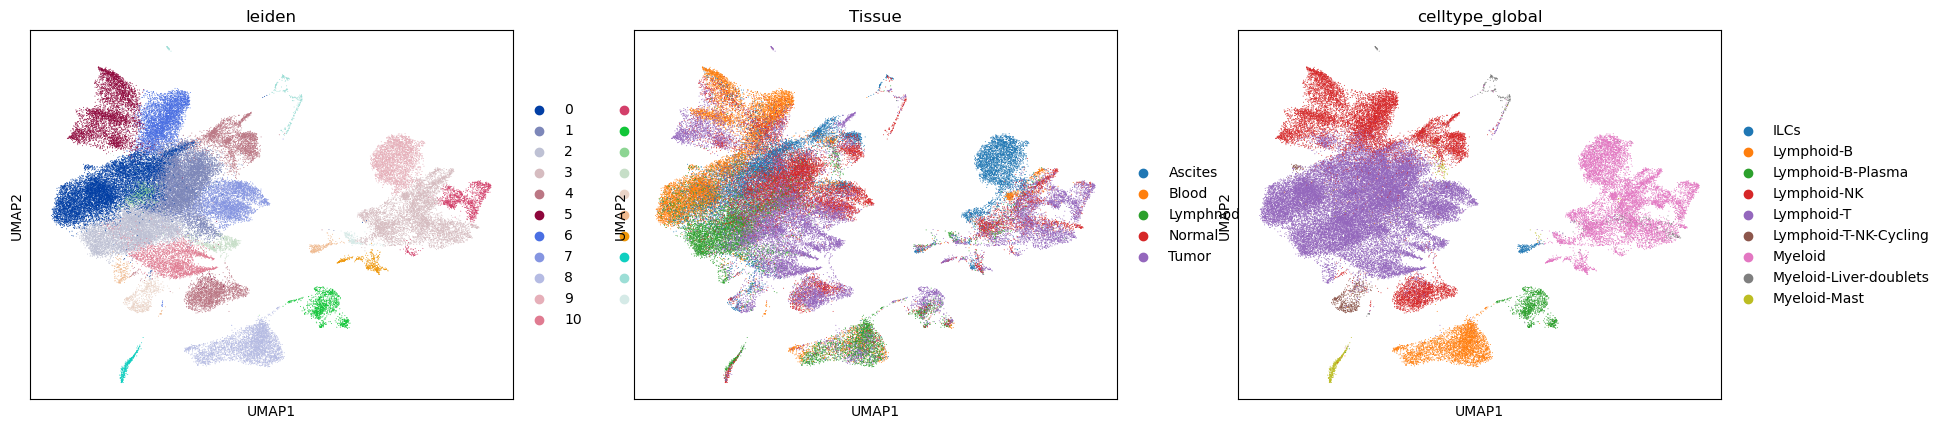

In [19]:
# 1. 군집화
# resolution이 높으면 더 잘게 쪼개지고, 낮으면 큼직하게 묶임
sc.tl.leiden(adata, resolution=0.5)

# 2. UMAP 좌표 계산 (2차원으로 투영)
sc.tl.umap(adata)
# 3. 시각화
# leiden(클러스터 번호), tissue(조직), PTPRC(CD45)
# PTPRC(CD45+)는 빼고, 클러스터(leiden), 조직(Tissue), 이미 알려진 세포타입(celltype_global)만 확인
sc.pl.umap(adata, color=['leiden', 'Tissue', 'celltype_global'])

UMAP 그래프는 수만 개의 세포들을 '유전자 발현 패턴이 얼마나 비슷한가?'를 기준으로 2차원 평면 위에 배치한 지도

/Users/jeongminpark/miniforge3/envs/hcc_project/lib/python3.10/site-packages/anndata/_core/anndata.py:1758: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


Tissue
Tumor     18539
Normal    13478
Name: count, dtype: int64


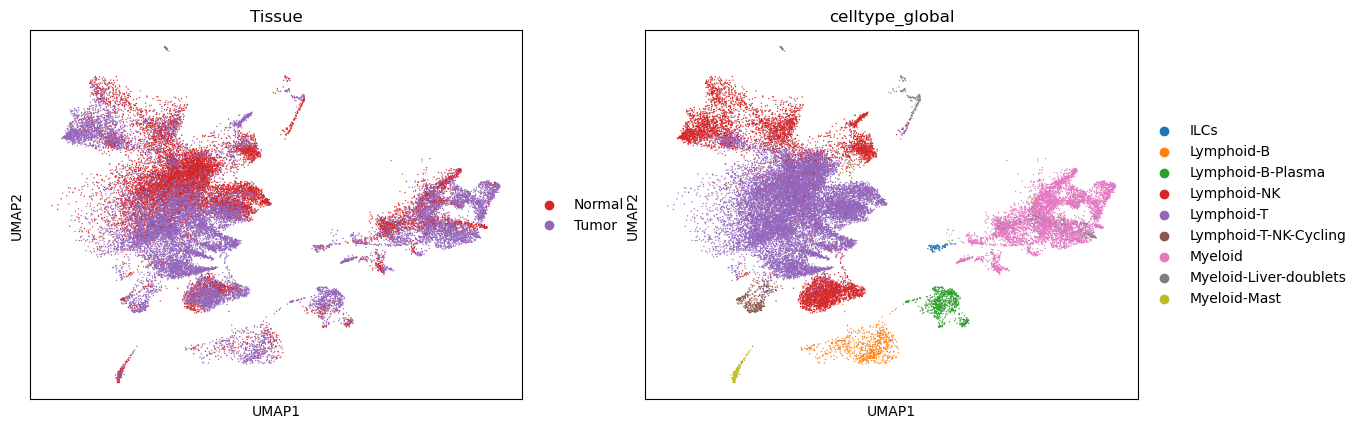

In [20]:
# 1. 'Tumor'와 'Normal'인 세포만 골라내서 따로 저장
adata_subset = adata[adata.obs['Tissue'].isin(['Tumor', 'Normal'])].copy()

# 2. 도수 분포표
print(adata_subset.obs['Tissue'].value_counts())

# 3. 필터링된 데이터로 UMAP 그리기
sc.pl.umap(adata_subset, color=['Tissue', 'celltype_global'])

tumor, normal cell이 겹치는 부위 : 유전적 거리가 가까움  
cell type 시각화 : 동일한 cell type 내에서 tumor vs normal의 차이가 발생  
세포가 암화되더라도 동일 cell type 내 cell 간의 거리가 cell type 간의 거리보다 더 가까움 ; 유전적으로 유사.

# 데이터 분석

/Users/jeongminpark/miniforge3/envs/hcc_project/lib/python3.10/site-packages/anndata/_core/anndata.py:1758: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/Users/jeongminpark/miniforge3/envs/hcc_project/lib/python3.10/site-packages/anndata/_core/anndata.py:1758: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


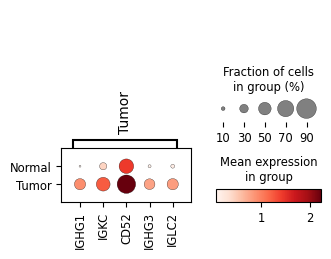

categories: Normal, Tumor
var_group_labels: Tumor


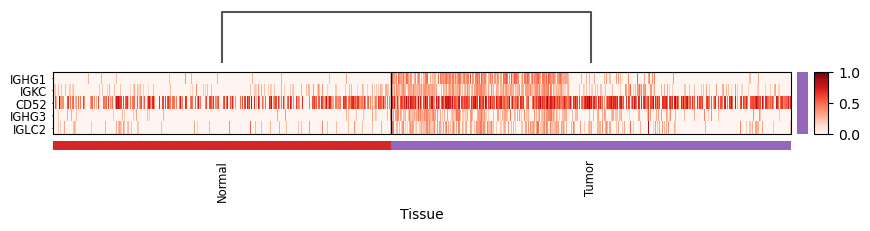

   names  logfoldchanges  pvals_adj
0  IGHG1        4.477731        0.0
1   IGKC        2.207679        0.0
2   CD52        1.388410        0.0
3  IGHG3        3.173824        0.0
4  IGLC2        2.714604        0.0


In [13]:
# 1. adata_subset에서 'Lymphoid-T'만 추출
adata_t = adata_subset[adata_subset.obs['celltype_global'] == 'Lymphoid-T'].copy()

# 2. 유전자 이름 중복 해결
adata_t.var_names_make_unique()

if adata_t.raw is not None:
    # raw 데이터를 잠시 꺼내서 수정하고 다시 넣는 과정
    raw_tmp = adata_t.raw.to_adata()
    raw_tmp.var_names_make_unique()
    adata_t.raw = raw_tmp


# 3. DEG 분석(Differentially Expressed Genes)
sc.tl.rank_genes_groups(adata_t, groupby='Tissue', method='wilcoxon', reference='Normal')

# 4. 시각화
sc.pl.rank_genes_groups_dotplot(adata_t, n_genes=5, groupby='Tissue', cmap='Reds')

# 히트맵
sc.pl.rank_genes_groups_heatmap(adata_t, n_genes=5, groupby='Tissue', 
                                standard_scale='var', cmap='Reds', swap_axes=True)

# 5. 데이터프레임 변환
# logfoldchanges가 높을수록 암 조직에서 발현량이 몇 배나 더 높음
deg_df = sc.get.rank_genes_groups_df(adata_t, group='Tumor')
print(deg_df.head(5)[['names', 'logfoldchanges', 'pvals_adj']])

# 결과가 LFC 순서가 아니라 종합 점수 LFC, p-value 고려한 종합 점수 순으로 출력됨.

pval < 0.05 : 통계적 유의미 
T-lymphocyte에서는 Ig를 생성하지 않음  
따라서 3번째인 CD52를 제외하고는 모두, noise로 간주  
tumor 조직에서는 plasma cell이 다수 존재하며, necrosis가 더 자주 발생하기 때문에 이런 이유로 발생한 것이라 유추.   
https://www.nature.com/articles/cdd2017173



제거 전 유전자 수: 26546
제거 후 유전자 수: 26378


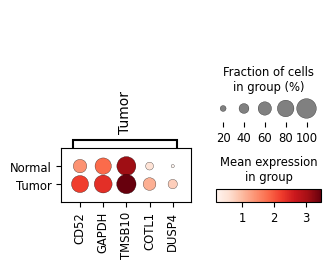

categories: Normal, Tumor
var_group_labels: Tumor


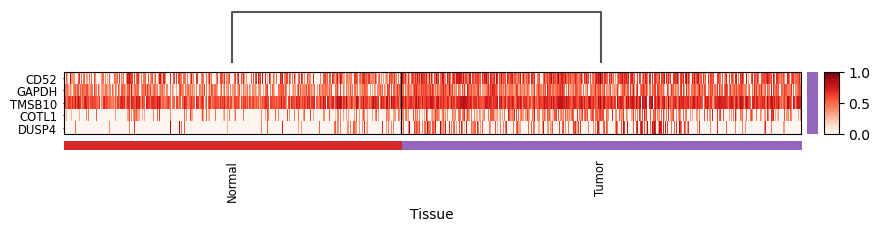

    names  logfoldchanges      pvals_adj
0    CD52        1.388410   0.000000e+00
1   GAPDH        0.912590  3.826220e-302
2  TMSB10        0.580775  5.442763e-298
3   COTL1        1.530820  3.470109e-246
4   DUSP4        2.649578  1.673601e-236


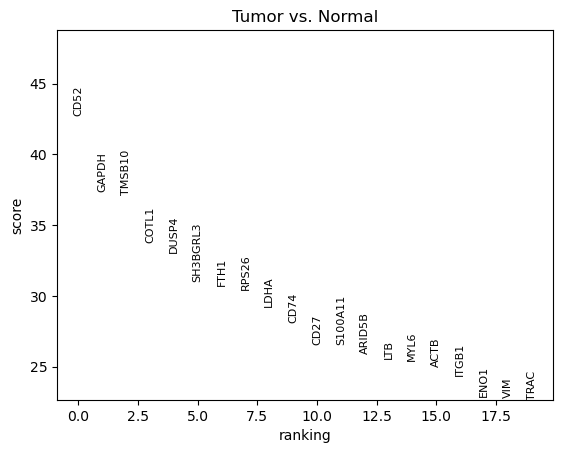

In [14]:
# 1. 지하실(raw)에 있는 데이터를 끄집어내서 새로운 객체로 만듦
# scanpy는 두 개의 저장소 .X/ .raw를 보유
# DEG 분석 통계 함수들은 raw 데이터를 주로 사용, 따라서 raw data에서 Ig 데이터를 삭제
adata_raw = adata_t.raw.to_adata()

# 2. 항체(IG) 유전자랑 미토콘드리아(MT) 유전자 찾기
# (대소문자 무시하고 확실하게 찾기 위해 대문자로 변환 후 검색)
ig_genes = adata_raw.var_names.str.upper().str.startswith('IG') 
mt_genes = adata_raw.var_names.str.upper().str.startswith('MT-')

# 3. 불필요한 유전자 제거 (항체도 아니고 AND 미토콘드리아도 아닌 것만 남김)
adata_final = adata_raw[:, ~(ig_genes | mt_genes)].copy()

print(f"제거 전 유전자 수: {adata_raw.n_vars}")
print(f"제거 후 유전자 수: {adata_final.n_vars}")

# 4. DEG
sc.tl.rank_genes_groups(adata_final, groupby='Tissue', method='wilcoxon', reference='Normal')

# 5. 결과 확인
sc.pl.rank_genes_groups_dotplot(adata_final, n_genes=5, groupby='Tissue', cmap='Reds')

sc.pl.rank_genes_groups_heatmap(adata_final, n_genes=5, groupby='Tissue', 
                                standard_scale='var', cmap='Reds', swap_axes=True)

# 데이터프레임
df_final = sc.get.rank_genes_groups_df(adata_final, group='Tumor')
print(df_final.head(5)[['names', 'logfoldchanges', 'pvals_adj']])


sc.pl.rank_genes_groups(adata_final, n_genes=20, sharey=False)

In [15]:
%pip install adjustText

Note: you may need to restart the kernel to use updated packages.


라벨링될 Top 5 유전자: ['CD52', 'GAPDH', 'TMSB10', 'COTL1', 'DUSP4']


Looks like you are using a tranform that doesn't support FancyArrowPatch, using ax.annotate instead. The arrows might strike through texts. Increasing shrinkA in arrowprops might help.


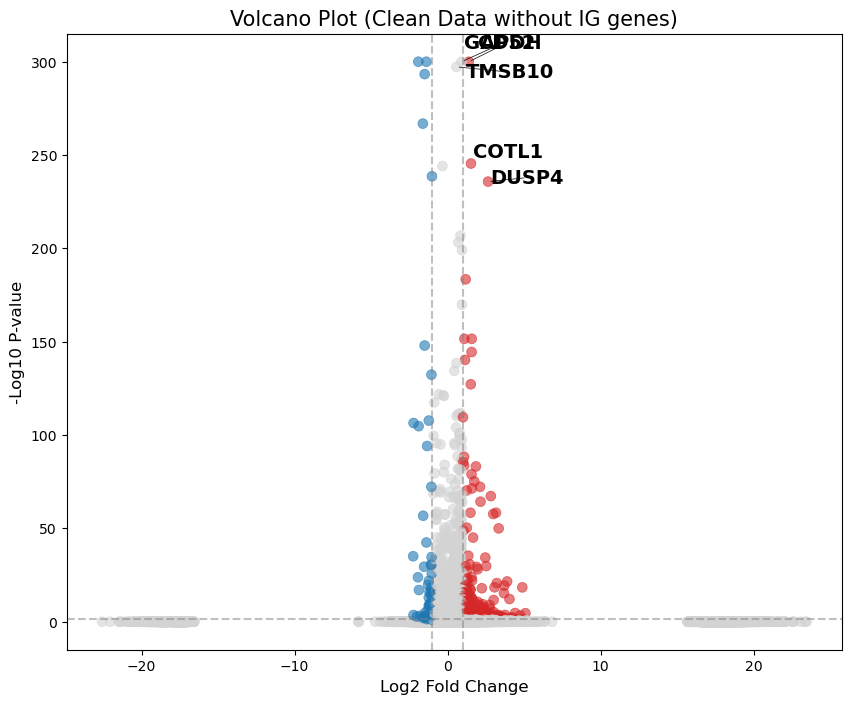

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from adjustText import adjust_text

# 1. 데이터 준비
# P-value를 그래프용 높이(-log10)로 변환
df_final['nlog10'] = -np.log10(df_final['pvals_adj'] + 1e-300)

# 2. 색깔 기준 설정
fc_thr = 1.0  # 2배 차이
pv_thr = -np.log10(0.05) # 유의성 기준

def map_color(row):
    if row['pvals_adj'] < 0.05 and row['logfoldchanges'] > fc_thr:
        return 'Tumor High'
    elif row['pvals_adj'] < 0.05 and row['logfoldchanges'] < -fc_thr:
        return 'Normal High'
    else:
        return 'NS'

df_final['color'] = df_final.apply(map_color, axis=1)

# 3. 상위 5개 유전자 자동 추출
top_5_genes = df_final.head(5)['names'].tolist()
print(f"라벨링될 Top 5 유전자: {top_5_genes}")

# 4. 그래프 그리기
plt.figure(figsize=(10, 8))
sns.scatterplot(data=df_final, x='logfoldchanges', y='nlog10', 
                hue='color',
                palette={'Tumor High': '#d62728', 'Normal High': '#1f77b4', 'NS': 'lightgrey'},
                s=50, alpha=0.6, edgecolor=None, legend=False)

# 5. 이름표 붙이기 (Top 5 자동 적용)
texts = []
for gene in top_5_genes:
    # df_final에서 해당 유전자 정보 찾기
    gene_data = df_final[df_final['names'] == gene]
    if not gene_data.empty:
        texts.append(plt.text(gene_data.iloc[0]['logfoldchanges'], 
                              gene_data.iloc[0]['nlog10'], 
                              gene, 
                              fontsize=14, fontweight='bold', color='black'))

# 6. 화살표로 예쁘게 정리
# force_points: 점(데이터)을 밀어내는 힘
# force_text: 글자끼리 밀어내는 힘
# expand_points: 점 주변 공간을 확보하는 정도
adjust_text(texts, force_points=0.2, force_text=0.5,
            expand_points=(1.2, 1.2), expand_text=(1.2, 1.2),
            arrowprops=dict(arrowstyle="-", color='black', lw=0.5))
# 7. 꾸미기
plt.axvline(x=fc_thr, linestyle='--', color='gray', alpha=0.5)
plt.axvline(x=-fc_thr, linestyle='--', color='gray', alpha=0.5)
plt.axhline(y=pv_thr, linestyle='--', color='gray', alpha=0.5)
plt.title('Volcano Plot (Clean Data without IG genes)', fontsize=15)
plt.xlabel('Log2 Fold Change', fontsize=12)
plt.ylabel('-Log10 P-value', fontsize=12)

plt.show()

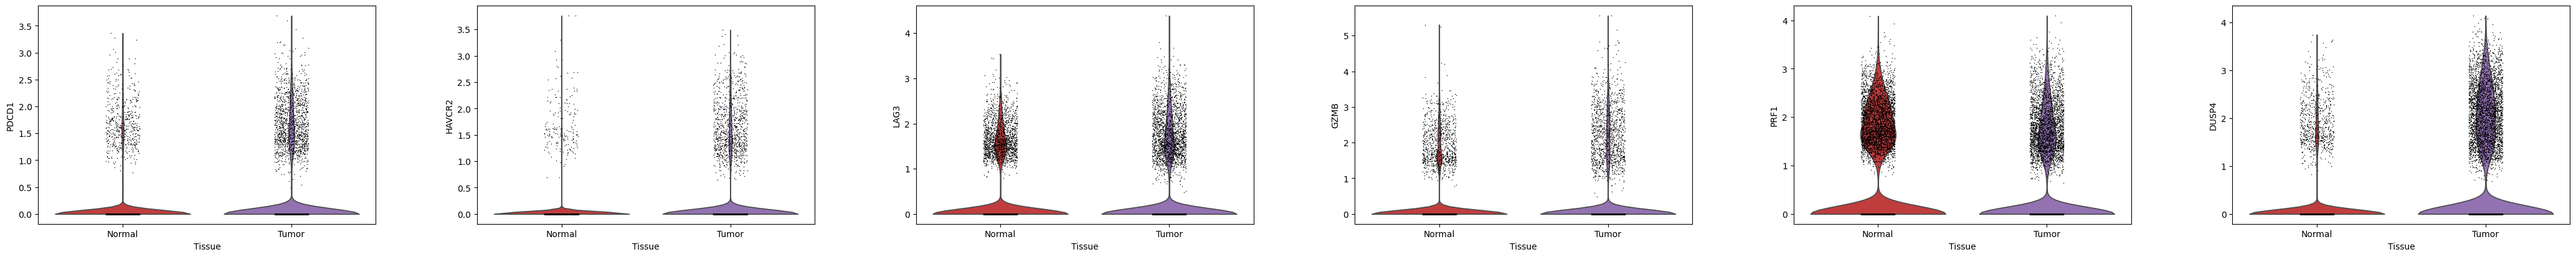

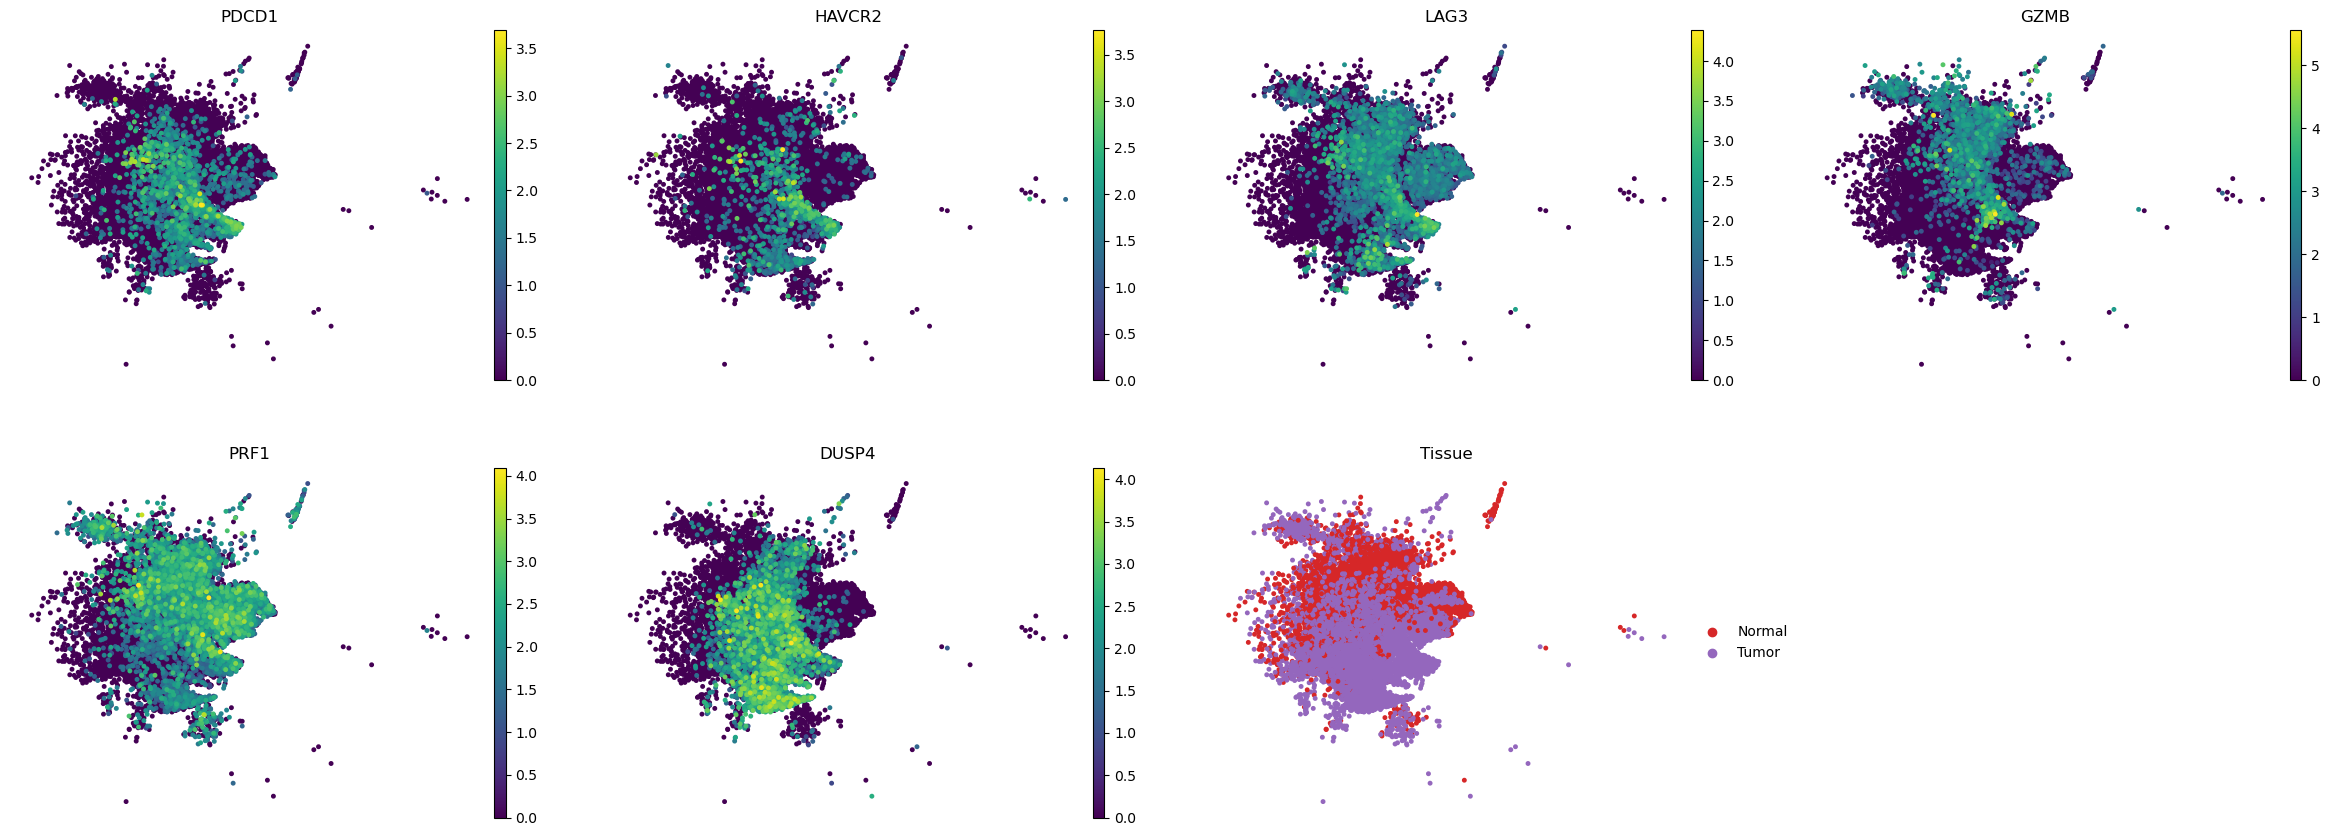

In [ ]:
# 핵심 마커
# Exhaustion 3 + Cytotoxicity 2
marker_genes = ['PDCD1', 'HAVCR2', 'LAG3', 'GZMB', 'PRF1', 'DUSP4']

# 1. 바이올린 플롯 (분포 비교)
# 암(Tumor) 쪽이 뚱뚱하게 올라와야 함
sc.pl.violin(adata_final, keys=marker_genes, groupby='Tissue')

# 2. UMAP 위에 뿌려보기 (어디에 뭉쳐있나?)
# 붉은 점들이 암 조직(Tumor) 위치랑 겹치는지 확인
sc.pl.umap(adata_final, color=marker_genes + ['Tissue'], frameon=False, s=50)

In [ ]:
import pandas as pd

# 1. 관심 있는 유전자들만 데이터프레임으로 꺼내기
genes_to_check = ['PDCD1', 'HAVCR2', 'LAG3', 'GZMB', 'DUSP4']
df = pd.DataFrame(adata_final[:, genes_to_check].X.toarray(), 
                  columns=genes_to_check, 
                  index=adata_final.obs_names)

# 2. 조직 정보(Tissue) 추가
df['Tissue'] = adata_final.obs['Tissue']

# 3. "발현율(%)" 계산 함수: (0보다 큰 세포 수 / 전체 세포 수) * 100
def get_fraction(x):
    return (x > 0).mean() * 100

percent_df = df.groupby('Tissue').apply(get_fraction)

# 4. 결과 출력 (소수점 1자리까지만)
print("=== 조직별 유전자 발현 세포 비율(%) ===")
print(percent_df.round(1))

=== 조직별 유전자 발현 세포 비율(%) ===
        PDCD1  HAVCR2  LAG3  GZMB  DUSP4
Tissue                                  
Normal    6.5     2.3  20.9  11.8    9.0
Tumor    15.0    10.4  22.0  13.0   37.2


/var/folders/ll/x3g7kv155vg89qfbdtx_p4_m0000gn/T/ipykernel_75906/943195297.py:16: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  percent_df = df.groupby('Tissue').apply(get_fraction)
